# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [140]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

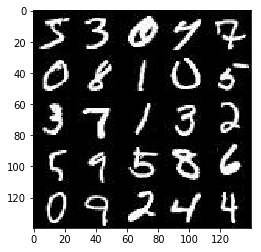

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

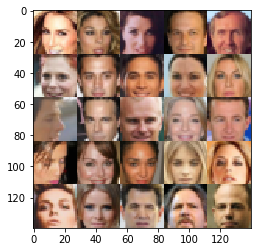

In [141]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="images")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32)

    return images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/jamesteow/anaconda/envs/python3-env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def leaky_relu(layer, alpha=0.2):
    return tf.maximum(alpha * layer, layer)

In [20]:
# CNN Params
kernel_size = 5
stride = 2

In [163]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Low-level implementation of conv2d
        # Default setting of padding is valid, very important
        # to ensuring the dimensionality of output is exactly what we want
        x1 = tf.layers.conv2d(images, 128, kernel_size, stride, padding='same')
        # x1 = tf.contrib.layers.conv2d(images, 128, kernel_size, stride)
        r1 = leaky_relu(x1, 0.15)
        # 14 x 14 x 128
        
        x2 = tf.layers.conv2d(r1, 256, kernel_size, stride, padding='same')
        # x2 = tf.contrib.layers.conv2d(r1, 256, kernel_size, stride)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        r2 = leaky_relu(bn2, 0.15)
        # 7 x 7 x 256
        
        x3 = tf.layers.conv2d(r2, 512, kernel_size, 1, padding='same')
        # x3 = tf.contrib.layers.conv2d(r2, 512, kernel_size, 1)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        r3 = leaky_relu(bn3, 0.15)
        # 7 x 7 x 512
        
        # Flatten layer
        f4 = tf.reshape(r3, (-1, 512*7*7))
        logits = tf.layers.dense(f4, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [165]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        x0 = tf.layers.dense(z, 7 * 7 * 512)
        x0 = tf.reshape(x0, (-1, 7, 7, 512))
        bn0 = tf.layers.batch_normalization(x0, training=is_train)
        r0 = leaky_relu(bn0)
        # 7 x 7 x 512
        
        x1 = tf.layers.conv2d_transpose(r0, 256, kernel_size, stride, padding='same')
        # x1 = tf.contrib.layers.conv2d_transpose(r0, 256, kernel_size, stride)
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        r1 = leaky_relu(bn1)
        # 14 x 14 x 256

        
        x2 = tf.layers.conv2d_transpose(r1, 128, kernel_size, stride, padding='same')
        # x2 = tf.contrib.layers.conv2d_transpose(r1, 128, kernel_size, stride)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        r2 = leaky_relu(bn2)
        # 28 x 28 x 128
        
        logits = tf.layers.conv2d_transpose(r2, out_channel_dim, kernel_size, 1, padding='same')
        # logits = tf.contrib.layers.conv2d_transpose(r2, out_channel_dim, kernel_size, 1)
        # 28 x 28 x 5
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [162]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # 1 - smooth, so that we can set smooth to zero if need be
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # From Salimans et al 2016:
    # To encourage the discriminator to estimate soft probabilities rather than to
    # extrapolate to extremely confident classification we can use a technique called
    # one-sided label smoothing
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [149]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    graph_keys = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [op for op in graph_keys if op.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [97]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [135]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, beta1=0.5):
        width, height, channels = real_size
        self.input_real, self.input_z, self.learning_rate = model_inputs(width, height, channels, z_size)
        self.learning_rate = learning_rate          
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, channels)
        self.d_train_opt, self.g_train_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [152]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # saver = tf.train.Saver()
    
    samples, losses = [], []
    batch_count = 0
    
    # Ignore the 0 dimension from data_shape which is the number of training examples
    real_shape = data_shape[1:]
    output_channel_dim = data_shape[-1]
    net = GAN(real_shape, z_dim, learning_rate, beta1)
    
    n_output_images = 25
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Multiply by 2.0 since data ranges from -0.5 to 0.5
                # while tanh logits range from -1 to 1
                batch_images = batch_images * 2.0
                
                # Add noise to G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_train_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_train_opt, feed_dict={net.input_z: batch_z})
                
                # Increment Batch Count
                batch_count += 1
                
                if (batch_count % 10 == 0):
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                    losses.append((train_loss_d, train_loss_g))
                    
                if (batch_count % 100 == 0):
                    # args: sess, n_images, input_z, out_channel_dim, image_mode
                    show_generator_output(sess, n_output_images, net.input_z, output_channel_dim, data_image_mode)
                

In [111]:
# 60000 refers to the number of training examples
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
data_shape = mnist_dataset.shape
print(data_shape[1:])
dimensions = data_shape[1:]
print(width, height, channels)
print(dimensions)

(28, 28, 1)
28 28 1
(28, 28, 1)


In [123]:
dimensions[-1]

1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7078... Generator Loss: 9.2359
Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 6.0981
Epoch 1/2... Discriminator Loss: 3.6452... Generator Loss: 0.0942
Epoch 1/2... Discriminator Loss: 1.7199... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 1.7837... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.6064... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.6736


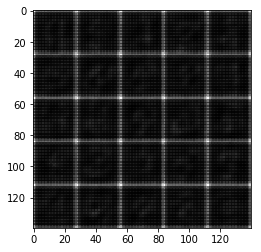

Epoch 1/2... Discriminator Loss: 1.0241... Generator Loss: 1.3976
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 2.2235
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.3907
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.7041
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.5282
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 2.0802
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 2.9132


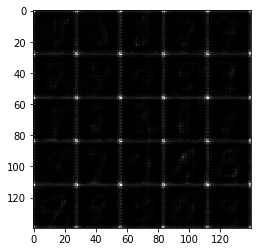

Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 2.2705
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 3.1633
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.1633


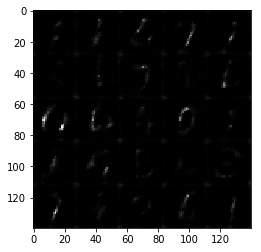

Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 1.7635... Generator Loss: 2.7756
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.8679
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 1.8742
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.5924


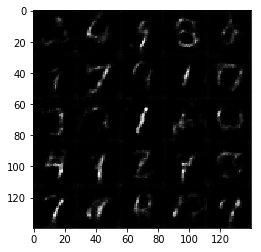

Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 1.7987
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 2.4299
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.9119
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.0566


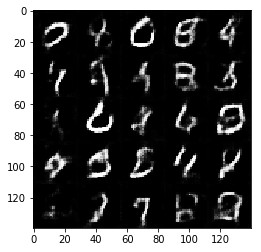

Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 2.1519
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.6908
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 2.2114
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.2428
Epoch 1/2... Discriminator Loss: 1.5646... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.1798
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 2.6815


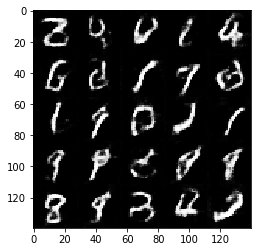

Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 1.1284
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.1719


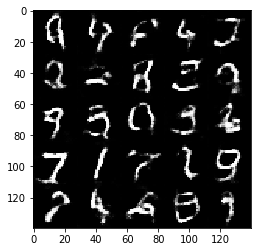

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 2.2407
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.8650
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.7245


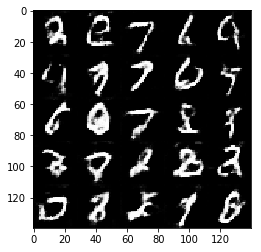

Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.8957
Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 1.9715
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 2.0976... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.7989... Generator Loss: 2.3922
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 2.7725
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.1132


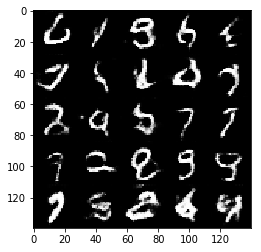

Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.4077
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.3842
Epoch 2/2... Discriminator Loss: 1.9533... Generator Loss: 0.3184
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.3024
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 0.9854


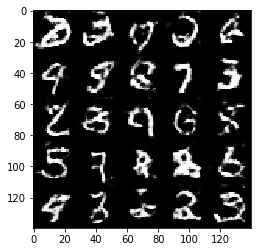

Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 2.1175
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 0.4753


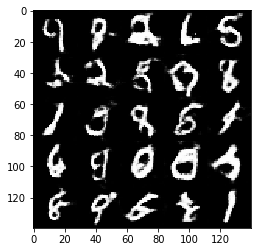

Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 2.1021
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.2472
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.7529
Epoch 2/2... Discriminator Loss: 1.7776... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.3072
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.4965


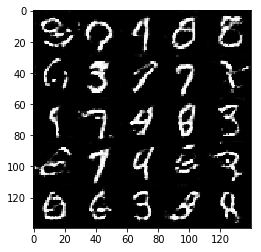

Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 1.9477
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.6259
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 2.9433
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 2.8882
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.2731
Epoch 2/2... Discriminator Loss: 1.7370... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 2.6241
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 2.6654


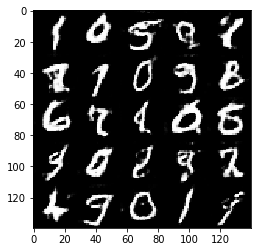

Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 1.1781
Epoch 2/2... Discriminator Loss: 1.7115... Generator Loss: 3.5224
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 2.9185
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 2.2081
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.6199
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.8458
Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 1.3812


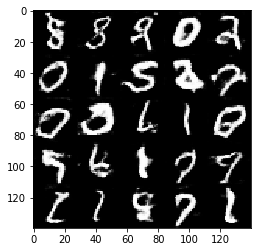

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 3.0800
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.6255
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.7910
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 2.1893
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 1.9144


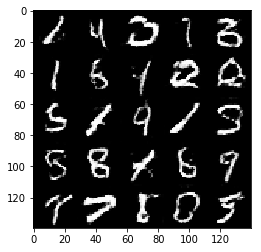

Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 3.2224
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.8939
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 2.7544... Generator Loss: 4.8152
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 1.5922... Generator Loss: 3.1472
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.5577
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.9707


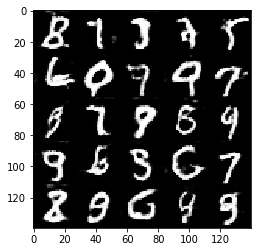

Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 2.4526
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.7015
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.4454
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.3725
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.6625
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 1.7397
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.7875


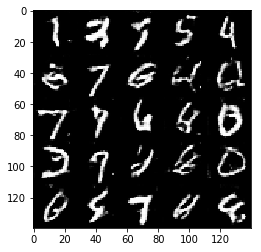

Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.9528
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.6791
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 2.5980
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 1.6147
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.8590


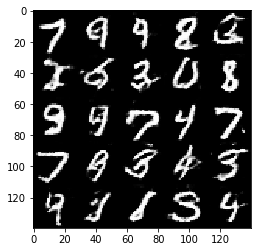

Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 2.0226
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 2.4846
Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 2.0883


In [167]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
# Test two:
# b_s = 64, z_dim = 100, lr = 0.0001, beta1 = 0.4
# Result worked okay for several steps before generator loss ballooned
# Generator loss increased to ~2, while discriminator decreased below 0.5
# Too much disparity between Generator and Discriminator
# Early cancel
# Possible reason: Did not correctly implement way for batch_norm layers to update their population stats

# Test three:
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0001
# beta1 = 0.4
# 
# Result: Improved images but blurry especially around eyes, and images are generally very muddy.

# Test four:
# Use Xavier Initialization in the Generator and Discriminator
# Result: Stopped early because the Generator loss started inflating while the Discriminator
# loss dropped dramatically

# Test five:
# Increased learning rate, decreased leaky relu alpha in the discriminator

Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 45.1083
Epoch 1/1... Discriminator Loss: 1.8441... Generator Loss: 22.4284
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 2.9706
Epoch 1/1... Discriminator Loss: 6.3341... Generator Loss: 13.6932
Epoch 1/1... Discriminator Loss: 3.7056... Generator Loss: 0.0858
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.8395
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 4.6963
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 2.4697
Epoch 1/1... Discriminator Loss: 2.0075... Generator Loss: 8.9739


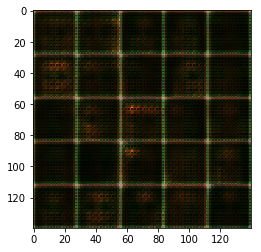

Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 7.0756
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 2.7537
Epoch 1/1... Discriminator Loss: 1.9270... Generator Loss: 4.8456
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.6699
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 2.6445
Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.3946


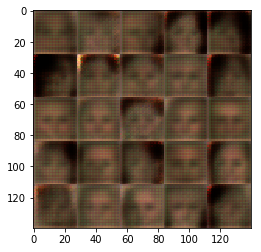

Epoch 1/1... Discriminator Loss: 1.8923... Generator Loss: 2.9239
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 2.2510
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 2.6420... Generator Loss: 0.1771
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 2.1645
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.6485
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 1.3962


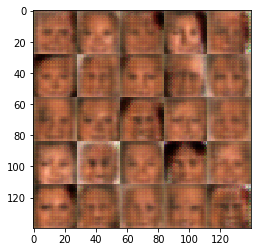

Epoch 1/1... Discriminator Loss: 1.8042... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 2.1960
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 1.6506


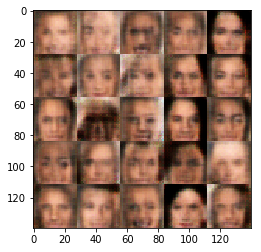

Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 2.3095
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.8429... Generator Loss: 1.8247
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 2.3865
Epoch 1/1... Discriminator Loss: 2.0626... Generator Loss: 0.2401
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.7214


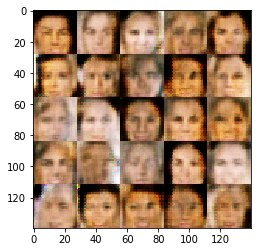

Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.8083
Epoch 1/1... Discriminator Loss: 1.7068... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 2.6951... Generator Loss: 3.3647
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.2817


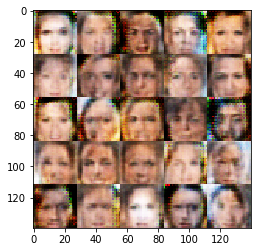

Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 2.1570


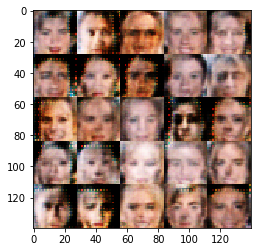

Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.3513
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 1.6930
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7683


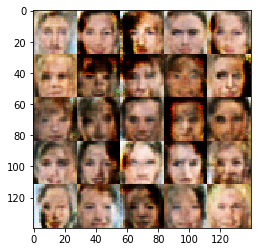

Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.6772... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 4.0402... Generator Loss: 2.6005
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.0668


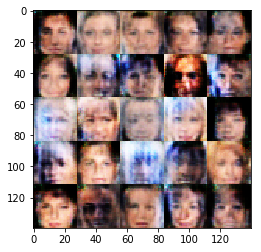

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 3.1161... Generator Loss: 0.0989
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 1.8113


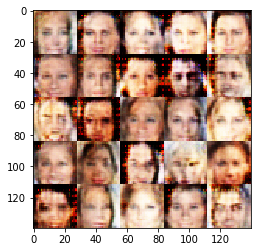

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.9038


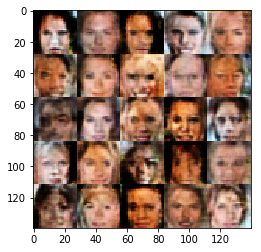

Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 2.0446
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.3389
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9191


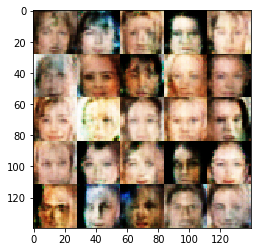

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 2.7184... Generator Loss: 2.9198
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.9980... Generator Loss: 0.3925


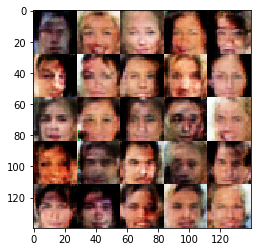

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.3548


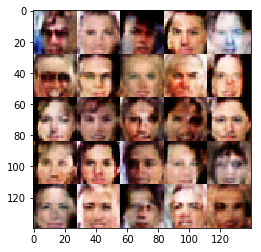

Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 1.7478... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5706


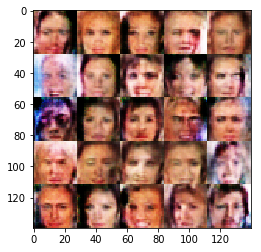

Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 2.9169
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.8268


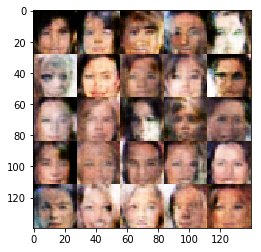

Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 1.7854


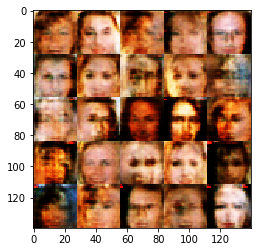

Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7145


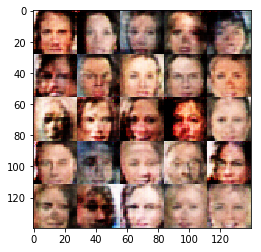

Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6509


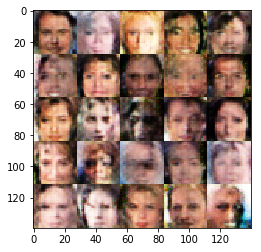

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.6422
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8653


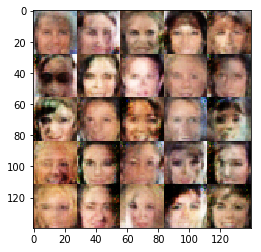

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 1.8090
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0926


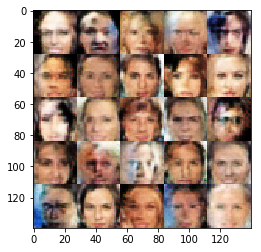

Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6804


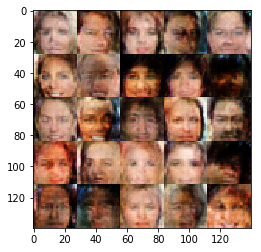

Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7401


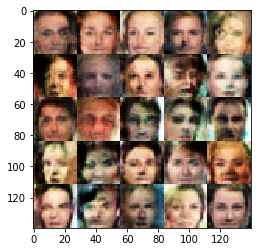

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8468


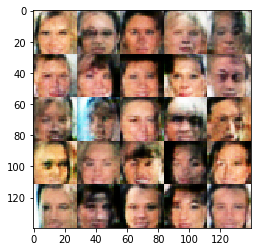

Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7284


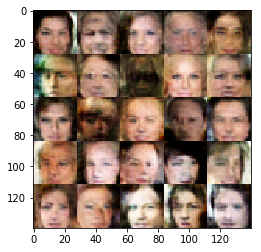

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1145


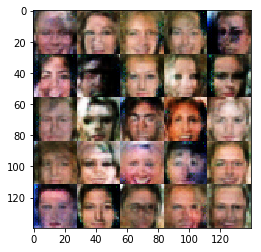

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.1762


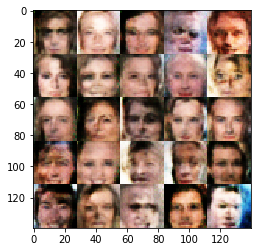

Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 1.3987
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9105


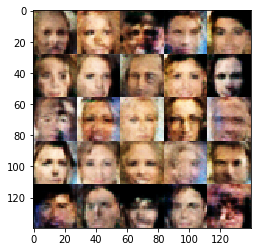

Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5531


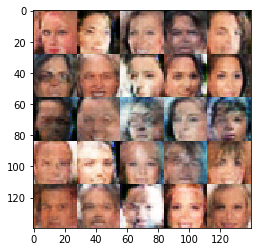

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5427


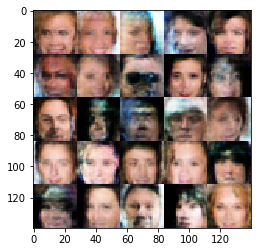

Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 2.1523
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.7340


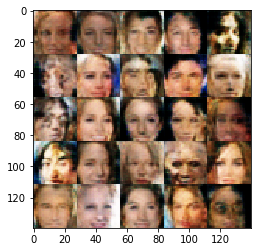

Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.4914
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8793


In [166]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.